
# Interactive MC-GPU-PET Simulation Demo

Welcome to this educational guide on Positron Emission Tomography (PET) simulation using **MC-GPU-PET**. 

PET is a nuclear imaging technique that produces a three-dimensional image of functional processes in the body. The system detects pairs of gamma rays emitted indirectly by a positron-emitting radionuclide (tracer), which is introduced into the body on a biologically active molecule.

## What is MC-GPU-PET?
MC-GPU-PET is a powerful GPU-accelerated Monte Carlo simulation tool that accurately models the physics of photon transport, including:
- **Photoelectric absorption**
- **Compton scattering**
- **Rayleigh scattering**

It simulates the entire acquisition process, from positron emission to detection, generating realistic raw data (sinograms) and images.

In this notebook, we will:
1.  **Configure** a simulation for a standard NEMA IEC phantom.
2.  **Run** the simulation using a Python wrapper.
3.  **Visualize** and interpret the results (Images and Sinograms).


In [1]:

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from mcgpu import MCGPUWrapper

# # Ensure we are in the project root to find modules
# if not os.getcwd() in sys.path:
#     sys.path.append(os.getcwd())

# Setup for better visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.cmap'] = 'inferno'



## 1. Initializing the Wrapper

We use a Python wrapper `MCGPUWrapper` to handle the complexity of the input files and binary outputs. We point it to the compiled executable.


In [2]:

# Initialize the wrapper
# We use 'sample_simulation' as the working directory so it finds the voxel file 'nema_iec_128.vox'.
# The executable and material files are now bundled with the installed 'mcgpu' package.
wrapper = MCGPUWrapper(
    working_dir='sample_simulation',
    verbose=True
)



## 2. Configuring simulated PET Physics

To run a simulation, we need to define the **Physics** and **Geometry**.

### The Phantom (NEMA IEC)
We are using a voxelized representation of the NEMA IEC Body Phantom, used for benchmarking PET scanners. It contains spheres of different sizes that can be filled with activity.

### Activity Levels
PET tracks activity (Becquerels). 
- **Scatter**: Photons that change direction before detection.
- **Trues**: Coincidence pairs that arrive without scattering (what we want).
- **Randoms**: (Not modeled in this specific config, but important in real life).

### Geometry Visualization
The diagram below illustrates the key geometry variables:
- **Detector Height**: The axial extent of the scanner.
- **Detector Radius**: The distance from the center.
- **Negative Radius**: As shown in the annotation, a negative radius tells MC-GPU to automatically center the detector on the voxelized phantom.

![PET Geometry Diagram](./pet_geometry_diagram.png)


In [3]:

params = {
    # Scan Time: A short scan for demonstration (5 seconds)
    'time_sec': 5.0,  
    
    # Random Seed: For reproducibility
    'random_seed': 42,
    
    # Activities (Material Index, Activity in Bq)
    # Material 1: Air/Background (Low activity)
    # Material 2: Water/Phantom Body (High activity source)
    'activities': [
        (1, 1000.0),   
        (2, 50000.0)
    ],
    
    # File resources
    'voxel_file': 'nema_iec_128.vox',
    
    # Scanner Geometry (Matching NEMA standard)
    # Units are in cm.
    # Reference from original input file (e.g., sample_simulation/MCGPU-PET.in):
    # "CYLINDRIC DETECTOR CENTER, HEIGHT, AND RADIUS: X, Y, Z, H, RADIUS [cm]"
    # "IF RADIUS<0: DETECTOR CENTERED AT THE CENTER OF THE VOXELIZED GEOMETRY"
    'detector_height': 25.0, # [cm] Axial coverage
    'detector_radius': -15.0, # [cm] Negative value centers detector on voxel geometry center
    
    # Sinogram Dimensions
    'fov_z': 25.0,
    'num_rows': 128, 
    'num_crystals': 504,
    'num_angles': 252,
    'num_rad_bins': 256,
    'image_res': 128
}



## 3. Running the Simulation

We now trigger the simulation. The wrapper will:
1. Generate an input file `.in`.
2. Call the CUDA executable.
3. Parse the resulting `.raw.gz` files into NumPy arrays.

> **Note**: This runs on the GPU. Please ensure you have a CUDA-capable device available.


In [4]:

print("Running simulation... this may take a moment.")
results = wrapper.run(params)
print("Simulation complete! Keys available:", results.keys())


Running simulation... this may take a moment.
Running command: /home/sarah/Dev/MCGPU-PET/mcgpu/MCGPU-PET.x mcgpu_input_42.in
Working directory: /home/sarah/Dev/MCGPU-PET/sample_simulation
narg= 2 


     *****************************************************************************
     ***                                                                       ***
     ***            MCGPU-PET_v0.1  (based on MC-GPU_v1.3)                     ***
     ***                                                                       ***
     ***     -Distribution:                                                    ***
     ***            https://github.com/DIDSR/MCGPU-PET                         ***
     ***                                                                       ***
     ***     -Authors:                                                         ***
     ***        MCGPU code foundation and PET source sampling implemented by:  ***
     ***          - Andreu Badal (Andreu.Badal-Soler[a


    -- Reading the input file 'mcgpu_input_42.in':

    -- Seed used in the execution '42':
       Material dose deposition tally ENABLED.
       3D voxel dose deposition tally DISABLED.

       PSF file correctly allocated (20000000 elements, 839.233398 Mbytes)
                   PET acquistion time = 5.000000 s
                     mean life isotope = 70000.000000
                  Activity material 1 = 1000.000000 Bq
                  Activity material 2 = 50000.000000 Bq
                      Input voxel file = nema_iec_128.vox
                   initial random seed = 42

   ----- Factor OBJECT = 1.000000 

    -- Reading voxel file 'nema_iec_128.vox':
         (note that MC-GPU can also read voxel and material files compressed with gzip)
       Number of voxels in the input geometry file: 128 x 128 x 128 =  2097152
       Size of the input voxels: 0.250000 x 0.250000 x 0.250000 cm  (voxel volume=0.015625 cm^3)
       Voxel bounding box size: 32.000000 x 32.000000 x 32.000000 cm



In [5]:
results

{'sinogram_Trues': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0,


## 4. Visualizing Results: 3D Images

MC-GPU produces voxelized images of where emissions were detected.
- **Trues**: The ideal image.
- **Scatter**: Noise caused by photon interactions in the body.

Let's look at the **True Coincidences**.


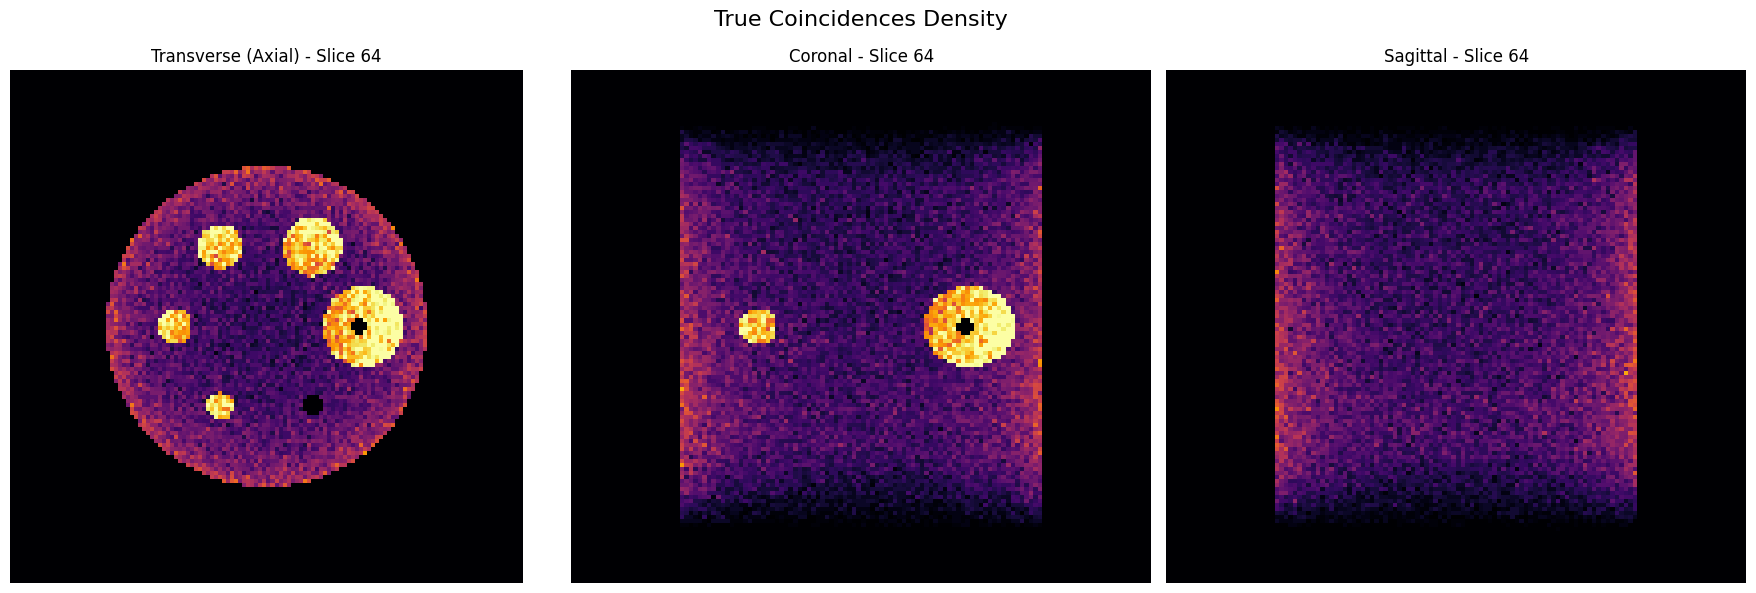

In [6]:

# Extract the 3D volume
vol_trues = results['image_Trues']

# Normalize for display
vmax = np.percentile(vol_trues, 99.9)

# Show Orthogonal Views (Transverse, Coronal, Sagittal)
center_z = vol_trues.shape[0] // 2
center_y = vol_trues.shape[1] // 2
center_x = vol_trues.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(vol_trues[center_z, :, :], vmin=0, vmax=vmax)
axes[0].set_title(f'Transverse (Axial) - Slice {center_z}')
axes[0].axis('off')

axes[1].imshow(vol_trues[:, center_y, :], vmin=0, vmax=vmax, aspect='auto') # Aspect might depend on voxel size
axes[1].set_title(f'Coronal - Slice {center_y}')
axes[1].invert_yaxis() # Traditional medical view orientation
axes[1].axis('off')

axes[2].imshow(vol_trues[:, :, center_x], vmin=0, vmax=vmax, aspect='auto')
axes[2].set_title(f'Sagittal - Slice {center_x}')
axes[2].invert_yaxis()
axes[2].axis('off')

plt.suptitle("True Coincidences Density", fontsize=16)
plt.tight_layout()
plt.show()



## 5. Visualizing Results: Sinograms

The **Sinogram** is the raw data format of PET. It represents lines of response (LORs).
- **X-axis**: Radial position (distance from center).
- **Y-axis**: Angle of the projection.

A point source in space traces a sinusoidal path in the sinogram (hence the name).


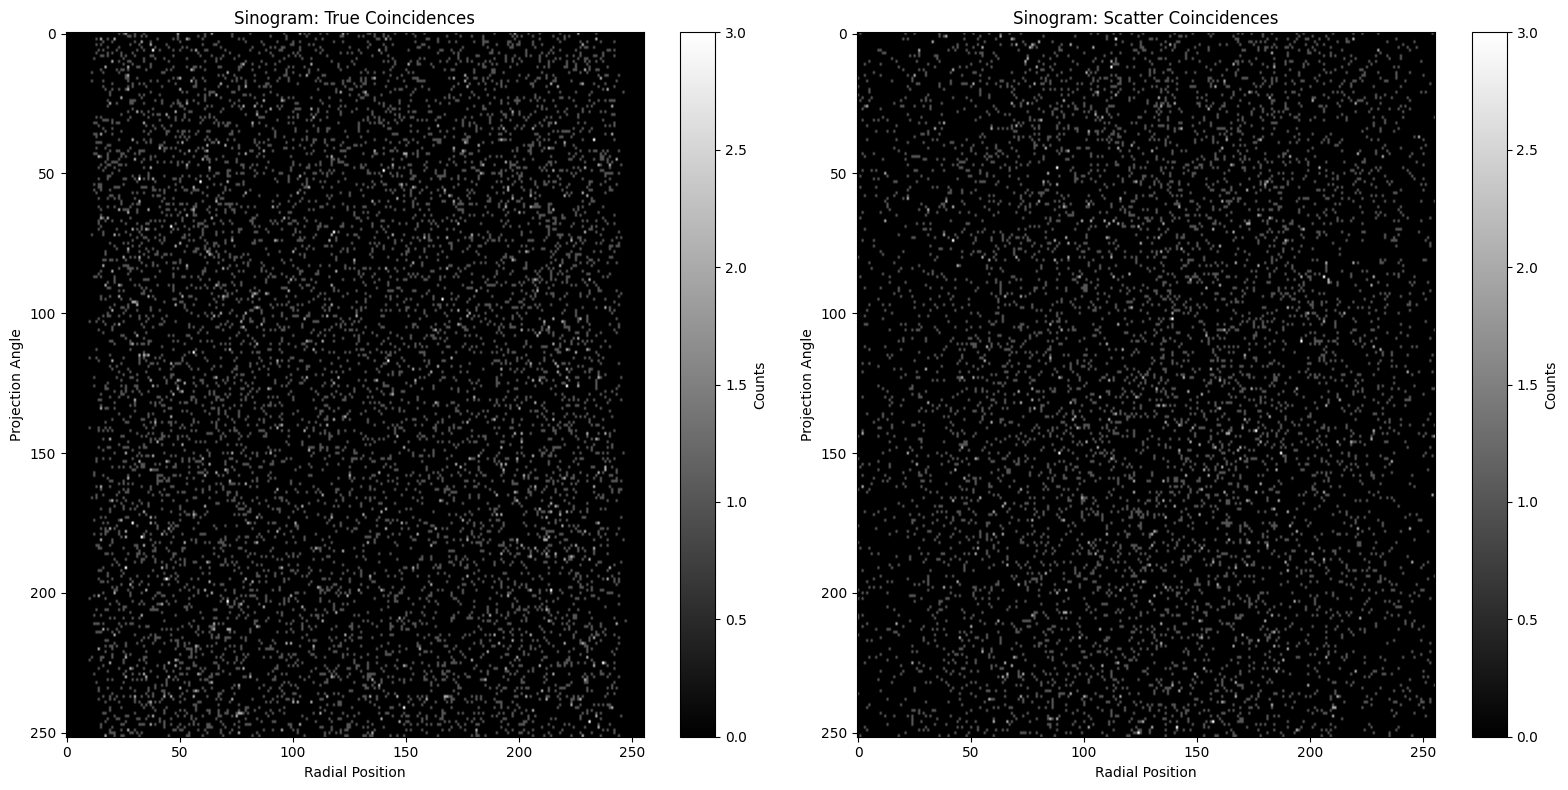

In [7]:

# Extract the 3D Sinogram stack (Sinograms, Angles, Radial)
sino_trues = results['sinogram_Trues']
sino_scatter = results['sinogram_Scatter']

# Pick a central sinogram plane
plane_idx = sino_trues.shape[0] // 2

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Trues
im1 = axes[0].imshow(sino_trues[plane_idx, :, :], cmap='gray', aspect='auto')
axes[0].set_title('Sinogram: True Coincidences')
axes[0].set_xlabel('Radial Position')
axes[0].set_ylabel('Projection Angle')
plt.colorbar(im1, ax=axes[0], label='Counts')

# Plot Scatter
im2 = axes[1].imshow(sino_scatter[plane_idx, :, :], cmap='gray', aspect='auto')
axes[1].set_title('Sinogram: Scatter Coincidences')
axes[1].set_xlabel('Radial Position')
axes[1].set_ylabel('Projection Angle')
plt.colorbar(im2, ax=axes[1], label='Counts')

plt.tight_layout()
plt.show()


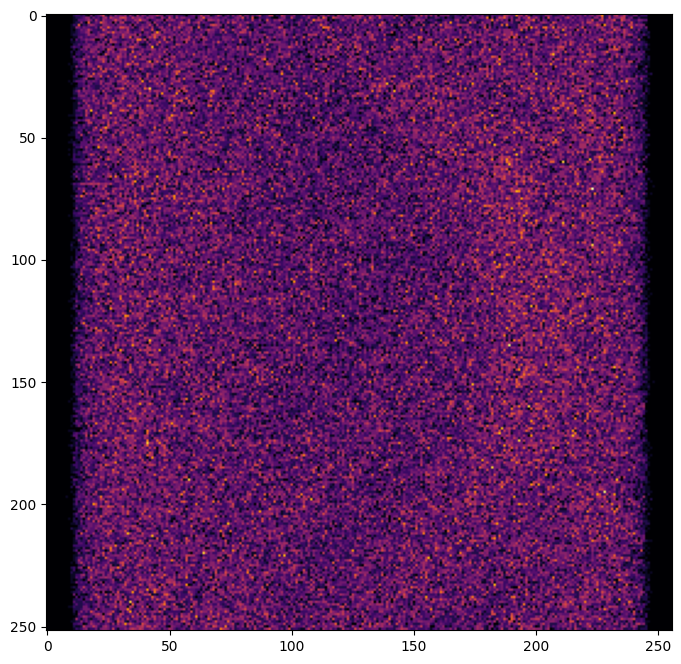

In [8]:
max_idx = np.argmax(sino_trues.sum(axis=(1,2)))
width = 20
plt.imshow(sino_trues[max_idx - width//2: max_idx + width//2].mean(axis=0))


## 6. Analysis: True vs. Scatter

One of the major challenges in PET image reconstruction is correcting for scatter. Let's compare the intensity profiles.


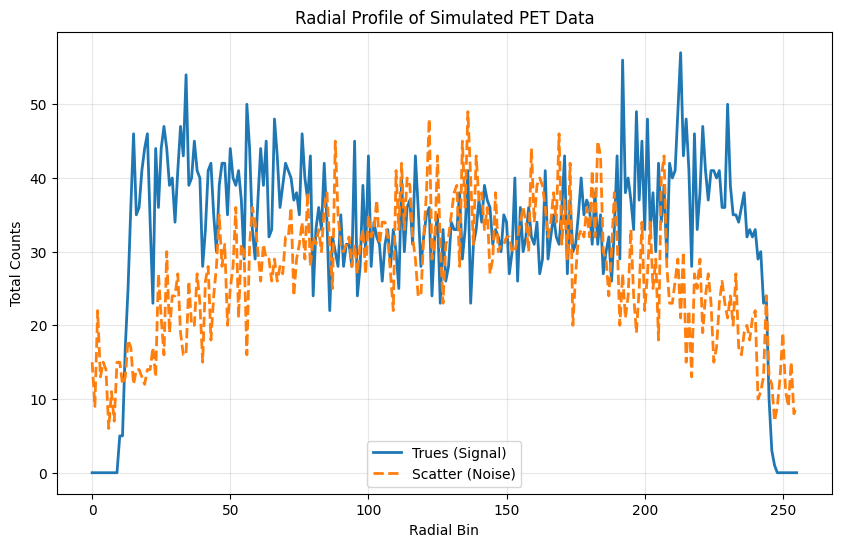

In [9]:

# Sum over all angles to get a radial profile for that plane
profile_true = np.sum(sino_trues[plane_idx, :, :], axis=0)
profile_scatter = np.sum(sino_scatter[plane_idx, :, :], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(profile_true, label='Trues (Signal)', linewidth=2)
plt.plot(profile_scatter, label='Scatter (Noise)', linewidth=2, linestyle='--')
plt.title('Radial Profile of Simulated PET Data')
plt.xlabel('Radial Bin')
plt.ylabel('Total Counts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## Conclusion

We successfully simulated a PET scan of a NEMA phantom!
- We generated **True** events (signal) and **Scatter** events (noise).
- We visualized the **Voxelized Output** (direct estimation of activity).
- We visualized the **Sinograms** (raw raw data used for reconstruction).

This wrapper allows you to programmatically modify physics parameters. 

### Next Steps: Custom Phantoms
Want to simulate your own patients or custom geometries? 
Check out the supplementary notebook: **[Creating Custom Phantoms](./MCGPU_PET_Phantom_Creation.ipynb)**.
